#Prepared by Tamal Acharya

#Build a Multi-Agent System with LangGraph: A Complete Tutorial on Agent Orchestration

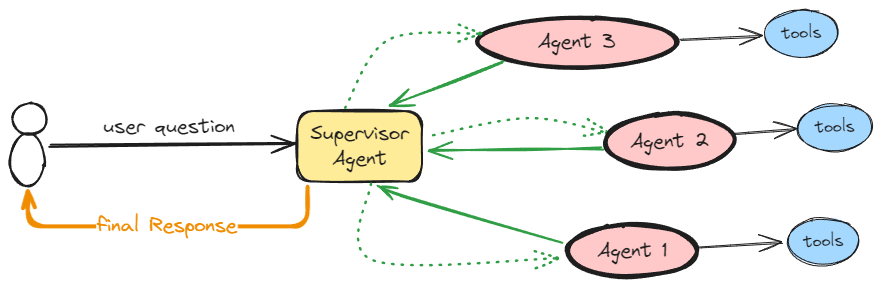

In [ ]:
#Setting up the Environment
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers


In [ ]:
#Setting up API Keys
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
#_set_env("OPENAI_API_KEY")
_set_env("GEMINI_API_KEY")


In [ ]:
#Creating the LLM Object
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model_name="gpt-4o")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0.7)


In [ ]:
#Create Tools
#WebSearch Tool Integration
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

In [ ]:
#Agentic RAG Tool Integration
#Load Documents:
 from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader

 def load_documents(folder_path: str) -> List[Document]:
     documents = []
     for filename in os.listdir(folder_path):
         file_path = os.path.join(folder_path, filename)
         if filename.endswith('.pdf'):
             loader = PyPDFLoader(file_path)
         elif filename.endswith('.docx'):
             loader = Docx2txtLoader(file_path)
         else:
             print(f"Unsupported file type: {filename}")
             continue
         documents.extend(loader.load())
     return documents

 folder_path = "/content/docs"
 documents = load_documents(folder_path)
 print(f"Loaded {len(documents)} documents from the folder.")





In [ ]:
 #Split Text into Chunks
 text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000,
     chunk_overlap=200,
     length_function=len
 )

 splits = text_splitter.split_documents(documents)
 print(f"Split the documents into {len(splits)} chunks.")


In [ ]:
#Generate Embeddings
 from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

 embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


In [ ]:
#Create and Persist a Vector Store:
 from langchain_chroma import Chroma

 collection_name = "my_collection"
 vectorstore = Chroma.from_documents(
     collection_name=collection_name,
     documents=splits,
     embedding=embedding_function,
     persist_directory="./chroma_db"
 )


In [ ]:
#Build the Retriever Tool:
 from langchain.tools import tool
 from pydantic import BaseModel

 class RagToolSchema(BaseModel):
     question: str

 @tool(args_schema=RagToolSchema)
 def retriever_tool(question):
   """Tool to Retrieve Semantically Similar documents to answer User Questions related to FutureSmart AI"""
   print("INSIDE RETRIEVER NODE")
   retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
   retriever_result = retriever.invoke(question)
   return "\n\n".join(doc.page_content for doc in retriever_results)


In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
# pass question
retriever_results = retriever.invoke("Who is the founder of Futuresmart AI?")
print(retriever_results)


In [ ]:
#NL2SQL Tool Integration
#Set Up the Database
 !wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
 !mv Chinook_Sqlite.sqlite Chinook.db


In [ ]:
#Initialize the Database Connection
 from langchain_community.utilities import SQLDatabase

 db = SQLDatabase.from_uri("sqlite:///Chinook.db")


In [ ]:
#Clean SQL Queries
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


In [ ]:
#Create the NL2SQL Tool
 from langchain.chains import create_sql_query_chain
 from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
 from operator import itemgetter
 import re
 from langchain_core.output_parsers import StrOutputParser
 from langchain_core.prompts import PromptTemplate
 from langchain_core.runnables import RunnablePassthrough, RunnableLambda

 class SQLToolSchema(BaseModel):
     question: str

 @tool(args_schema=SQLToolSchema)
 def nl2sql_tool(question):
   """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
   print("INSIDE NL2SQL TOOL")
   execute_query = QuerySQLDataBaseTool(db=db)
   write_query = create_sql_query_chain(llm, db)

   chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
   )

   response = chain.invoke({"question": question})
   return response['result']


In [ ]:
#Test the Tool
 question = "How many employees are there?"
 result = nl2sql_tool.invoke({"question": question})
 print(f"Answer: {result}")


In [ ]:
#Combining the Tools
tools = [web_search_tool, retriever_tool, nl2sql_tool]
llm_with_tools = llm.bind_tools(tools)


In [ ]:
#Building the LangGraph
#Steps to Build the LangGraph
 from typing import Annotated
 from langgraph.graph import StateGraph
 from langgraph.graph.message import add_messages

 class State(TypedDict):
     messages: Annotated[list, add_messages]


In [ ]:
#Add Nodes: Add nodes for the chatbot and tools to handle user queries and invoke the tools.
 def chatbot(state: State):
     return {"messages": [llm_with_tools.invoke(state["messages"])]}

 graph_builder = StateGraph(State)
 graph_builder.add_node("chatbot", chatbot)

 tool_node = ToolNode(tools=[web_search_tool, retriever_tool, nl2sql_tool])
 graph_builder.add_node("tools", tool_node)


In [ ]:
#Define Edges: Use conditional edges to determine when the agent should switch between nodes.
 from langgraph.prebuilt import tools_condition

 graph_builder.add_conditional_edges("chatbot", tools_condition)
 graph_builder.add_edge("tools", "chatbot")
 graph_builder.set_entry_point("chatbot")


In [ ]:
#Compile the Graph: Finalize the graph for execution.
 graph = graph_builder.compile()


In [ ]:
#Testing the AI Agent
#Interactive Testing
config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


In [ ]:
#Visualizing the LangGraph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Error generating graph visualization.")


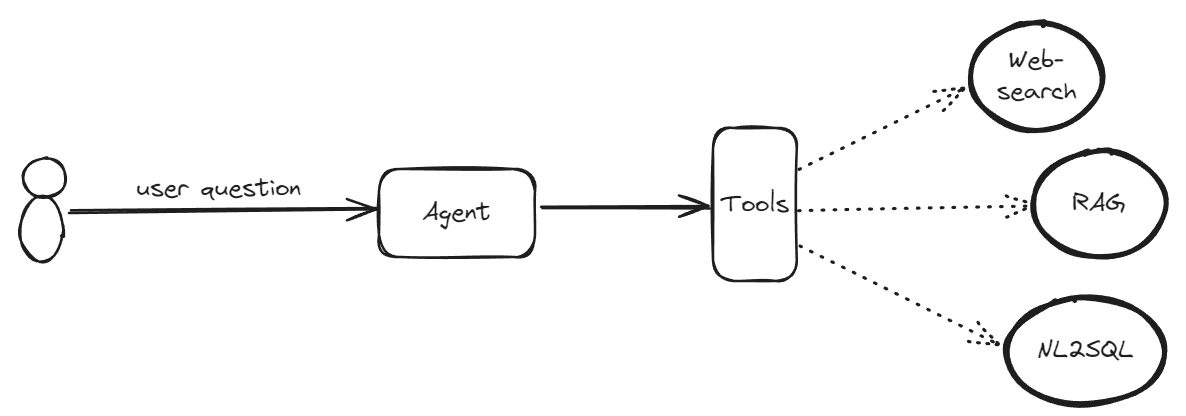

In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command

# Define available agents
members = ["web_researcher", "rag", "nl2sql"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]

# Create system prompt for supervisor
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["web_researcher", "rag", "nl2sql", "FINISH"]

# Create supervisor node function
def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)


In [ ]:
#Implementing Individual Agents
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()


In [ ]:
#Web Research Agent
websearch_agent = create_agent(llm, [web_search_tool])

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )


In [ ]:
#RAG Agent
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )


In [ ]:
#NL2SQL Agent
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )


In [ ]:
#Putting It All Together
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()


In [ ]:
#Visualizing the LangGraph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass


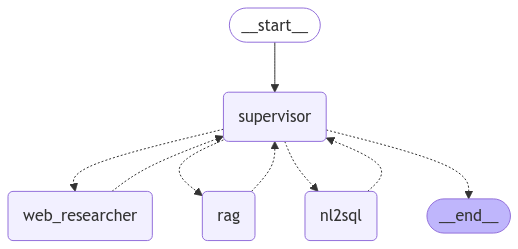

In [ ]:
#Testing the System
# Example: Complex Query Using Multiple Agents
input_question = "Find the founder of FutureSmart AI and then do a web research on him"
for s in graph.stream(
    {"messages": [("user", input_question)]},
    subgraphs=True
):
    print(s)
    print("----")
